**Preliminares:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import random as rd
from scipy.misc import derivative

**Funciones SSH:**

In [2]:
def H_t1_t2(N, t1, t2, PBC = False):
    Matriz = np.zeros((N,N))

    a = 0 #diagonal
    b = -t2 #1 + delta #la que aparece despues - en este caso sería -t2
    c = t1 #1 - delta #la que aparece primero - en este caso sería t1

    for i in range(N):
        Matriz[i,i] = a
    for i in range(N-1):
        if (i%2 == 0):
            Matriz[i+1,i] = c
            Matriz[i,i+1] = c
        else:
            Matriz[i+1,i] = b
            Matriz[i,i+1] = b
            
    if PBC:
        Matriz[0,N-1] = b #PBC
        Matriz[N-1,0] = b #PBC
            
    return Matriz  

def Diagonalizar(Matriz):
    
    eig_vals, eig_vecs = np.linalg.eig(Matriz)
    eig_vals_sorted = np.sort(eig_vals)
    eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()]
    
    N = Matriz.shape[0]
    D = np.identity(N)*eig_vals_sorted
    Q = np.asmatrix(eig_vecs_sorted)

    return D, Q, np.asmatrix(Matriz)

def Estado_Base(D,U):
    i = 0
    while D[i,i] <= 0:
        i = i +1
    indice = i #Ese es la energía del estado base:    
    Vec_Est_Base = U[:,indice]
    lambda_base = D[indice,indice]
    
    return Vec_Est_Base/np.linalg.norm(Vec_Est_Base), lambda_base #Retornemoslo normalizado

**Coeficientes de Lanczos**

Supongamos que conocemos los momentos:

In [3]:
M = [1, 2, 120, 4, 7] #M_0, M_1, M_2, M_3, M_4

In [4]:
def M_sub_k_sup_n(k,n):    
    if(n == 0): return ((-1)**k)*M[k]
    else: return L_sub_k_sup_n(k, n-1) - L_sub_k_sup_n(n - 1, n-1)*(M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def L_sub_k_sup_n(k,n):   
    if(n == 0): return ((-1)**(k+1))*M[k+1]
    else: return (M_sub_k_sup_n(k+1, n)/M_sub_k_sup_n(n,n)) - (M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def a_n(n):
    return -1*L_sub_k_sup_n(n,n)

def b_n_cuadrado(n):
    if n==0: return 0
    else: return M_sub_k_sup_n(n,n)

**Testeo de las relaciones de recurrencia:**

In [5]:
a_n(1)

-4.0344827586206895

In [6]:
(M[3] - M[1]**3)/(M[2] - M[1]**2) -2*M[1]

-4.0344827586206895

In [7]:
M[3]

4

In [8]:
b_n_cuadrado(1)

116.0

In [9]:
(M[2] - M[1]**2)

116

In [10]:
((M[4] - M[1]*M[3])/(M[2] - M[1]**2) - M[2] -1*((M[1]**3 - M[3])/(M[2] - M[1]**2) +2*M[1])*((M[1]**3 - M[3])/(M[2] - M[1]**2) + M[1]))

-128.2167063020214

In [11]:
b_n_cuadrado(2)

-128.2167063020214

In [12]:
for i in range(100):
    global M
    M = [1] + [rd.randint(1,200) for n in range(4)] #M_0, M_1, M_2, M_3, M_4
    
    if not(np.isclose(a_n(0), M[1])): print('Está fallando')
    if not(np.isclose(a_n(1), (M[3] - M[1]**3)/(M[2] - M[1]**2) -2*M[1])): print('Está fallando')
    if not(np.isclose(b_n_cuadrado(1), (M[2] - M[1]**2))): print('Está fallando')
    if not(np.isclose(b_n_cuadrado(2), ((M[4] - M[1]*M[3])/(M[2] - M[1]**2) - M[2] -1*((M[1]**3 - M[3])/(M[2] - M[1]**2) +2*M[1])*((M[1]**3 - M[3])/(M[2] - M[1]**2) + M[1])))): print('Está fallando') 

Las relaciones funcionan bien, hagamos una función que permita calcular los coeficientes:

In [13]:
def a_coef():
    coef = []
    for i in range(len(M)):
        try: coef.append(a_n(i))
        except: break
    return coef    

def b_coef_cuadrado():
    coef = []
    for i in range(len(M)):
        try: coef.append(b_n_cuadrado(i))
        except: break
    return coef   

def lanczos_coefs():
    a_coefs = a_coef()
    b_coefs = b_coef_cuadrado()
    
    for i in range(1, len(b_coefs)):
        if np.isclose(b_coefs[i],0): 
            a_coefs = a_coefs[:i]
            b_coefs = b_coefs[:i]
            break
        
    return a_coefs, b_coefs

In [14]:
M = [1, 2, 120, 4, 7, 10]

In [15]:
a = [1,2,3]

In [16]:
a[:2]

[1, 2]

In [17]:
[a_n(0), a_n(1), a_n(2)], a_coef()

([2, -4.0344827586206895, 2.066220142147112],
 [2, -4.0344827586206895, 2.066220142147112])

In [18]:
[b_n_cuadrado(0), b_n_cuadrado(1), b_n_cuadrado(2)], b_coef_cuadrado()

([0, 116.0, -128.2167063020214], [0, 116.0, -128.2167063020214])

In [19]:
lanczos_coefs()

([2, -4.0344827586206895, 2.066220142147112], [0, 116.0, -128.2167063020214])

**Testeo (8. Time evolution of spread complexity in quenched - Mir Afrasiar):**

In [20]:
def S(t):
    global q1_f, q2_f, k
    
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    sin_thetaf = np.abs(r1)/rf
    
    return np.cos(rf*t) - 1j*cos_thetaf*np.sin(rf*t)

def LE(t):
    return -1*np.log10(np.abs(S(tiempos)))

def a_0(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    
    return -1*rf*cos_thetaf

def a_1(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    
    return rf*cos_thetaf

def b_1(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    sin_thetaf = np.abs(r1)/rf
    
    return rf*np.abs(sin_thetaf)

**Prueba 1:**

In [21]:
q1_f, q2_f, k = -1, 3, np.pi/2

/home/joaco/anaconda3/envs/root_lab/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


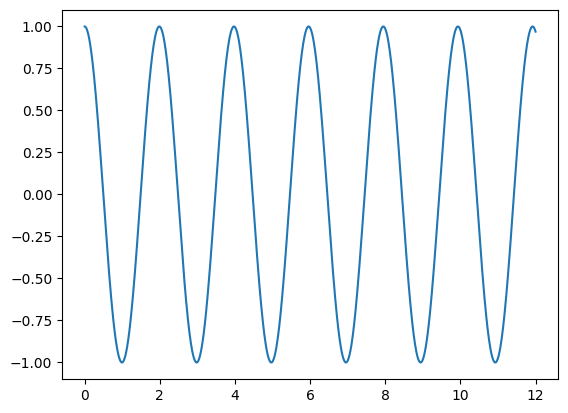

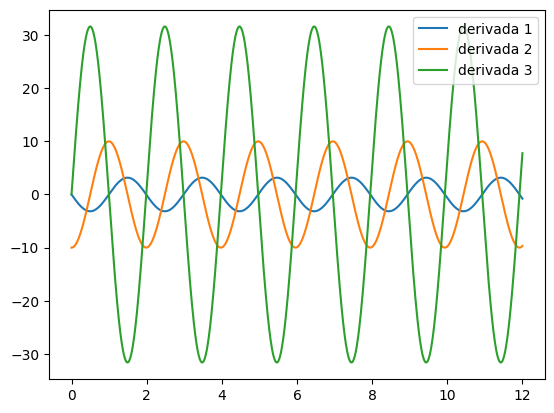

In [22]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()
for degree in range(1,4):
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order =  degree + degree%2 + 1), label = f'derivada {degree}')
plt.legend()

In [23]:
M = [1]

for degree in range(1,4):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order =  degree + degree%2 + 1))
M

[1, (-2.999500024999405-0j), (9.99916669444434-0j), (-29.992500749954907+0j)]

In [24]:
a_coef()

[(-2.999500024999405+0j), (2.999500025003503-0j)]

In [25]:
a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)

(-3.0, 3.0)

In [26]:
b_n_cuadrado(1)

(1.0021662944729073+0j)

In [27]:
b_1(q1_f, q2_f, k)**2

1.0000000000000004

In [28]:
lanczos_coefs()

([(-2.999500024999405+0j), (2.999500025003503-0j)],
 [0, (1.0021662944729073+0j)])

**Prueba 2:**

In [29]:
q1_f, q2_f, k = 1, 1.5, np.pi

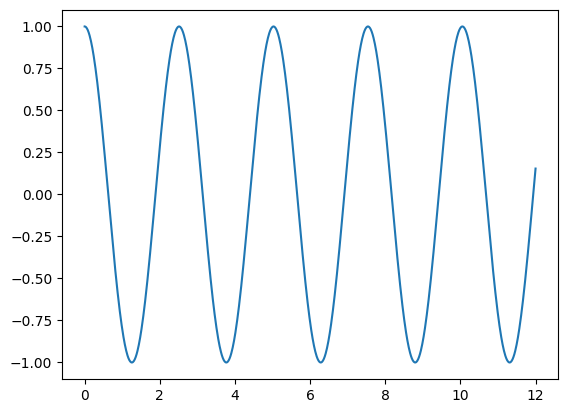

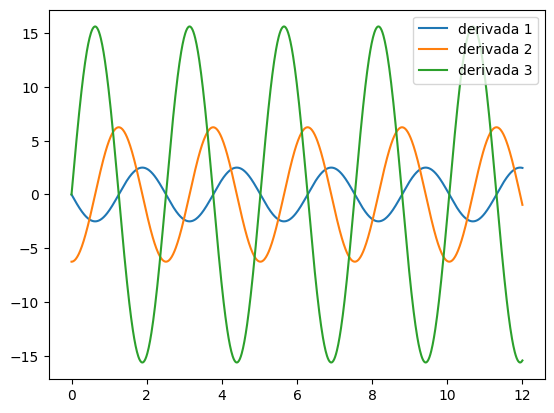

In [30]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()
for degree in range(1,4):
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order =  degree + degree%2 + 1), label = f'derivada {degree}')
plt.legend()

In [31]:
M = [1]

for degree in range(1,4):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))
M

[1,
 (-1.8367788536382947e-16-0j),
 (6.249674485947487-0j),
 (-1.1479269937909348e-15+0j)]

In [32]:
a_coef()

[(-1.8367788536382947e-16+0j), (1.836778853638579e-16-0j)]

In [33]:
a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)

(-1.8369701987210297e-16, 1.8369701987210297e-16)

In [34]:
b_coef_cuadrado()

[0, (6.249674485947487+0j)]

In [35]:
1, b_1(q1_f, q2_f, k)**2

(1, 6.25)

Probemos para muchas combinaciones:

In [36]:
q2_f_values = np.linspace(0.1,2,1000)

for q2_f in q2_f_values:

    q1_f, k = 1, np.pi

    M = [1]
    for degree in range(1,4):
        M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

    coef_calculados = a_coef() + b_coef_cuadrado()
    coef_teoricos = [a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)] + [0, b_1(q1_f, q2_f, k)**2]
    
    for i in range(len(coef_calculados)):
        if (np.abs(coef_calculados[i] - coef_teoricos[i]) > 0.001): print('Algo falla.')
        
q1_f_values = np.linspace(0.1,2,1000)

for q1_f in q1_f_values:

    q2_f, k = 1, np.pi

    M = [1]
    for degree in range(1,4):
        M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

    coef_calculados = a_coef() + b_coef_cuadrado()
    coef_teoricos = [a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)] + [0, b_1(q1_f, q2_f, k)**2]
    
    for i in range(len(coef_calculados)):
        if (np.abs(coef_calculados[i] - coef_teoricos[i]) > 0.001): print('Algo falla.')
        
k_values = np.linspace(-np.pi,np.pi,1000)

for k in k_values:

    q1_f, q2_f = 1, 1.5

    M = [1]
    for degree in range(1,4):
        M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

    coef_calculados = a_coef() + b_coef_cuadrado()
    coef_teoricos = [a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)] + [0, b_1(q1_f, q2_f, k)**2]
    
    for i in range(len(coef_calculados)):
        if (np.abs(coef_calculados[i] - coef_teoricos[i]) > 0.001): print('Algo falla.')

Tratemos de graficar esto para distintos q:

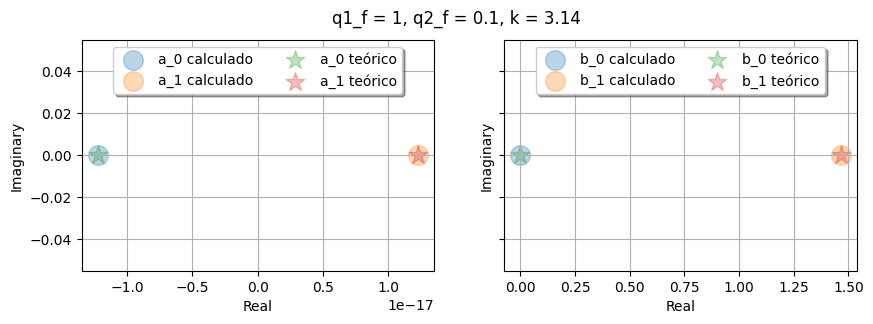

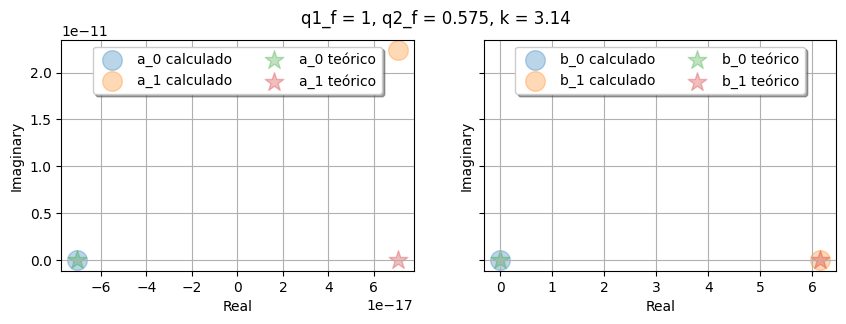

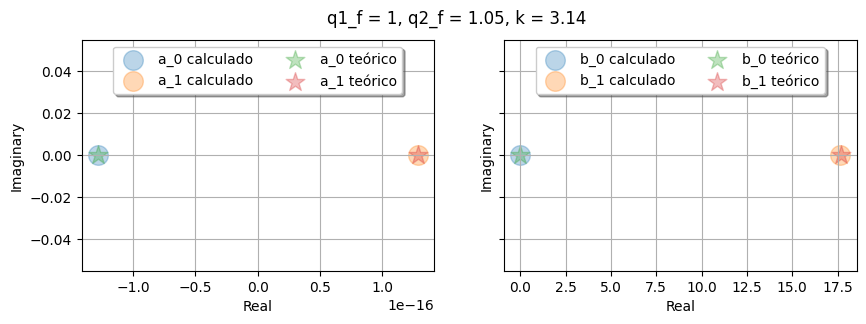

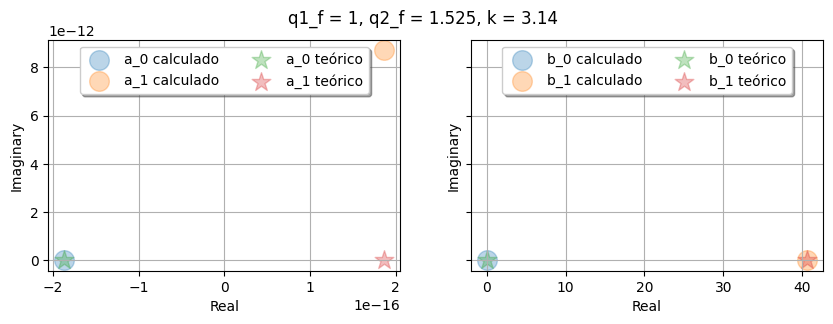

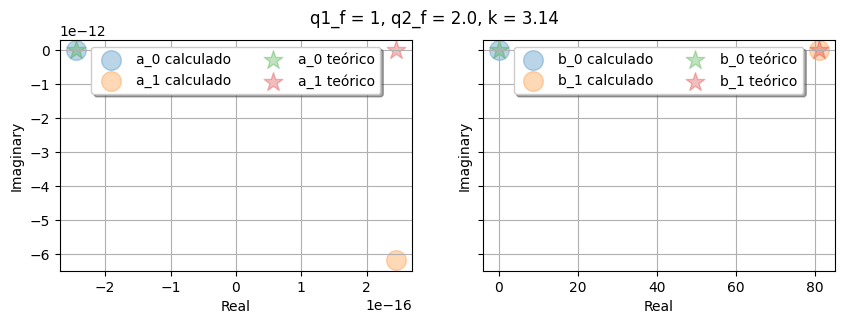

In [37]:
q2_f_values = np.linspace(0.1,2,5)

for q2_f in q2_f_values:

    q1_f, k = 1, np.pi
        
    fig = plt.figure(figsize = (10,3))
    gs = fig.add_gridspec(1, 2, wspace=0.2)
    (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

    M = [1]
    for degree in range(1,4):
        M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

    for n,coef in enumerate(a_coef()):
        ax1.scatter(coef.real, coef.imag, alpha = 0.3, s = 200, label = f'a_{n} calculado')
    
    for n,coef in enumerate([a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)]):
        ax1.scatter(coef.real, coef.imag, alpha = 0.3, s = 200, label = f'a_{n} teórico', marker = '*')
        
    ax1.grid()
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=True)
    ax1.set_xlabel('Real')
    ax1.set_ylabel('Imaginary')
    
    #fig = plt.figure(figsize= (4,4))
    
    for n,coef in enumerate(b_coef_cuadrado()):
        
        ax2.scatter((coef**2).real, (coef**2).imag, alpha = 0.3, s = 200, label = f'b_{n} calculado')
    
    for n,coef in enumerate([0, b_1(q1_f, q2_f, k)**2]):
        ax2.scatter((coef**2).real, (coef**2).imag, alpha = 0.3, s = 200, label = f'b_{n} teórico', marker = '*')
        
    ax2.grid()
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=True)
    ax2.set_xlabel('Real')
    ax2.set_ylabel('Imaginary')
    
    fig.suptitle(f'q1_f = {q1_f}, q2_f = {str(q2_f)[:8]}, k = {str(k)[:4]}')

**Observación:** Funciona bien, sin embargo hay que tener cuidado con las derivadas que calcula python. Si calculo más M me pueden aparecer M que divergen y coeficientes que nada que ver.

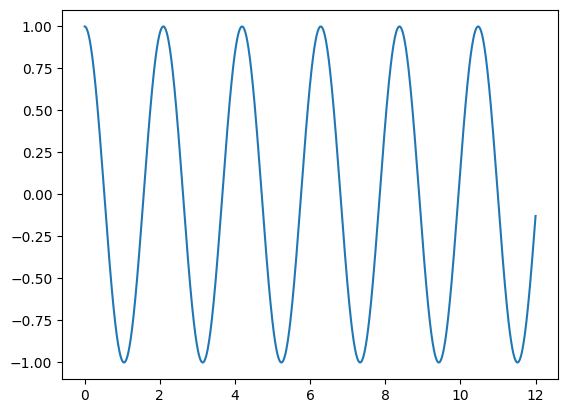

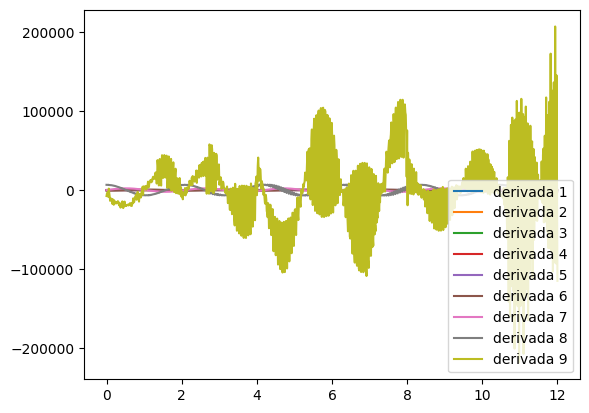

In [38]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()

M = [1]

for degree in range(1,10):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order = degree + degree%2 + 1), label = f'derivada {degree}')
plt.legend()

In [39]:
M

[1,
 (-2.448926220787339e-16-0j),
 (8.999325020249138-0j),
 (-2.203868301147374e-15-5.551115123125782e-11j),
 (80.98785072574442-4.622231866529365e-25j),
 (-1.983332708543541e-14+5.551115123125782e-07j),
 (728.8333270238921-2.002967142162725e-20j),
 (-1.7848709834004255e-13-0.19428902930940237j),
 (6640.24391028306+5.392603844284259e-16j),
 (-1.5546106511093764e-12+7549.516567451063j)]

In [40]:
a_coef()

[(-2.448926220787339e-16+0j),
 (2.448926220787553e-16-6.1683683061067e-12j),
 (-6.480666704443269e-16-5.894891132024692j),
 (2.0247894095979866e-15+84.64163549896477j),
 (-9.916872788512892e-16-31.937993613135838j)]

In [41]:
b_coef_cuadrado()

[0,
 (8.999325020249138+0j),
 (-1.048275599657696e-08-5.1361983883557747e-26j),
 (28268.411644283467+6.6254566700152e-14j),
 (-52469.095508160346-2.7997510496804674e-13j)]

**Idea:** Esto depronto se puede arreglar calculando ambos coeficientes al mismo tiempo, cuando el b valga cero entonces se acaba todo, así nada diverge.